In [1]:
import pickle
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)

import sys
sys.path.append('./../')

from datasets.dataset import _load_collection_real,_load_collection_syn
from models_utility.construct_models import _initialize_SMkernelhyp,_make_gpmodel
from models_utility.param_gp import Param



from kernels.RBF_kernel import RBF
from kernels.SM_kernel import SM
from scipy.linalg import norm as fnorm


from utility.eval_metric import _evaluate_metric
import matplotlib.pyplot as plt



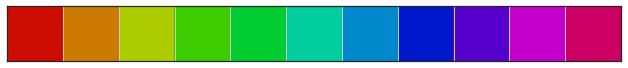

In [2]:
import seaborn as sns
sns.set()
sns.set_style('white')



plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.4, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [3]:
random_seed = 1000
device = True

#filename = 'SM_Q2_exp1'
filename = 'SM_Q5_exp1_unequal_v3'
x_train, x_test, x_full, y_train, y_test,y_full,Dataset = _load_collection_syn(filename, cuda_option=device)



#loaded collection#
/home/yohan/Myenv/Summit_Conference/ICML21_SMapproximation_Sumbit/test


In [4]:
setting_dict = {}
setting_dict['random_seed'] = random_seed
setting_dict['init_sample_num'] = 1000
setting_dict['input_dim'] = 1

setting_dict['Num_Q'] = 8
setting_dict['num_sample_pt'] = 3
setting_dict['num_batch'] = 1

setting_dict['lr_hyp'] = 0.001        

setting_dict['kl_option'] = True   
setting_dict['iter'] = 8000       
setting_dict['num_rep'] = 1
setting_dict['weight_rate'] = 0.05  
setting_dict['noise_err'] = 0.01*y_train.std()



setting_dict = _initialize_SMkernelhyp( x_train,y_train, setting_dict, random_seed)


In [5]:
#ith_model_name = 'equal_reg'
ith_model_name = 'weight_reg'

model = _make_gpmodel(model_name=ith_model_name, setting_dict=setting_dict, device=device)
model._set_data(x_train,y_train)

In [6]:
optimizable_param =  [*model.parameters(),model.likelihood.variance]
optimizable_param

[sf2 : tensor([0.], device='cuda:0'), weight : tensor([[0.2185],
         [0.2413],
         [0.0763],
         [0.0180],
         [0.0723],
         [0.2364],
         [0.0129],
         [0.0302]], device='cuda:0'), std : tensor([[-3.8327],
         [-3.0964],
         [-3.5288],
         [-3.4848],
         [-6.9078],
         [-6.9078],
         [-3.4727],
         [-2.5224]], device='cuda:0'), mu : tensor([[2.3787],
         [1.8541],
         [2.5964],
         [1.8337],
         [2.3888],
         [2.3842],
         [1.8077],
         [2.5971]], device='cuda:0'), std_prior : tensor([[-3.3928],
         [-5.2960],
         [-3.2436],
         [-2.6050],
         [-2.6933],
         [-6.6243],
         [-2.8873],
         [-3.2605]], device='cuda:0'), mu_prior : tensor([[-0.9668],
         [-2.2254],
         [-0.7595],
         [-0.9781],
         [-3.3675],
         [-1.6025],
         [-0.8985],
         [-1.8781]], device='cuda:0'), noise_variance : tensor([-3.3278], device='cu

In [7]:
optimizer = torch.optim.Adam(optimizable_param ,
                               lr=setting_dict['lr_hyp'],
                               betas=(0.9, 0.99),
                               eps=1e-08,
                               weight_decay=0.0)

In [8]:
observe_period = 100

In [9]:
for i in range(setting_dict['iter'] + 1):


    ith_tic = time.time()    
    optimizer.zero_grad()    
    ith_loss = model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])    
    
    ith_loss.backward()
    optimizer.step()

    
    
    with torch.no_grad():
        pred_train_mu, pred_train_var = model._predict(inputs_new=x_train)
        pred_test_mu, pred_test_var = model._predict(inputs_new=x_test)


    # out1 : root mean square (rmse)
    # out2 : mean negative log likelihood (mnll)
    #ith_rmse,ith_mnll = _evaluate_metric(pred_test_mu, pred_test_var, y_test)
    ith_rmse,ith_mnll = _evaluate_metric(pred_test_mu, pred_test_var, y_test)




    if i % observe_period == 0 :
        print('%d th loss0 : %.4f, test rmse : %.4f, test mnll: : %.4f' % (i,ith_loss.cpu().data.numpy(),ith_rmse,ith_mnll))
        try:
            print('self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance')            
            print(model.weight.exp().squeeze(),model.mu.exp().squeeze(),model.std.exp().squeeze(),model.likelihood.variance.transform()**2)

            print('\n')
            print('self.num_samplept_list_at')
            print(model.num_samplept_list_at)
        except:
            pass
        
        print('')

    
    




0 th loss0 : 33498737.1987, test rmse : 3.0327, test mnll: : 1425.4262
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.2455, 1.2741, 1.0804, 1.0192, 1.0761, 1.2680, 1.0140, 1.0317],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.7799,  6.3922, 13.4285,  6.2636, 10.8891, 10.8392,  6.1023, 13.4380],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0216, 0.0452, 0.0293, 0.0306, 0.0010, 0.0010, 0.0310, 0.0802],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0013], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[3, 4, 3, 3, 2, 2, 3, 4]

100 th loss0 : 27907044.6707, test rmse : 8.0420, test mnll: : 13082.8931
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.3154, 1.3349, 1.1483, 1.0597, 1.1315, 1.2892, 1.0327, 1.0966],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.7886,  6.4012, 13.5194,  6.3033, 10.8764,  9.8839,  6.1159, 13.3602],
       device='cuda:

1300 th loss0 : 4272437.8182, test rmse : 6.4035, test mnll: : 1089.5957
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([2.0402, 2.1416, 1.7293, 1.4889, 1.8765, 1.4337, 1.4935, 1.6541],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.7865,  6.2197, 13.4270,  6.3895, 10.8543,  3.6028,  6.1671, 13.4729],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0190, 0.0424, 0.0306, 0.0280, 0.0017, 0.0011, 0.0307, 0.0675],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0089], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[3, 4, 3, 3, 2, 2, 3, 4]

1400 th loss0 : 3707744.0559, test rmse : 21.2632, test mnll: : 8419.6760
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([2.1184, 2.2326, 1.8031, 1.5293, 1.9509, 1.4257, 1.5553, 1.7425],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.7889,  6.2211, 13.4302,  6.3899, 10.8580,  3.3169,  6.1232, 13.5079],
       device='cud

2600 th loss0 : 663781.7957, test rmse : 6.3090, test mnll: : 222.8387
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([3.3323, 2.4509, 2.7271, 2.3064, 3.3256, 0.6440, 2.5595, 2.8159],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.8392,  3.0124, 13.3945,  6.3164, 10.7738,  1.2353,  6.4114, 13.5540],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0185, 0.0408, 0.0324, 0.0244, 0.0031, 0.0007, 0.0289, 0.0572],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0656], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[3, 4, 3, 3, 2, 2, 3, 4]

2700 th loss0 : 599396.4301, test rmse : 6.3774, test mnll: : 157.8076
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([3.4854, 2.3617, 2.7923, 2.4088, 3.4768, 0.5863, 2.6511, 2.9573],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.8383,  2.7730, 13.3981,  6.2975, 10.7605,  1.1384,  6.4117, 13.4367],
       device='cuda:0',

3900 th loss0 : 198322.5668, test rmse : 8.3089, test mnll: : 51.8125
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([5.9432, 0.8377, 3.7690, 3.8383, 5.0222, 0.1842, 4.2709, 5.2161],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.7352,  1.0290, 10.8384,  6.2859, 10.3677,  0.4350,  6.4004, 13.3952],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0224, 0.0174, 0.0302, 0.0222, 0.0045, 0.0009, 0.0244, 0.0493],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.4462], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[4, 2, 3, 3, 2, 2, 3, 5]

4000 th loss0 : 189849.7594, test rmse : 7.2773, test mnll: : 43.8142
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([6.1800, 0.7581, 3.9812, 3.9885, 4.9776, 0.1671, 4.4892, 5.4684],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([10.5820,  0.9477, 10.8228,  6.3055, 10.0934,  0.4027,  6.4042, 13.4237],
       device='cuda:0', g

5200 th loss0 : 101038.1952, test rmse : 4.5054, test mnll: : 4.9351
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([7.3339, 0.2365, 7.4973, 4.6251, 4.9054, 0.0513, 5.5888, 8.4578],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 6.3620,  0.3566, 10.8169,  4.7030,  6.2577,  0.2019,  5.0074, 10.1029],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0263, 0.0060, 0.0247, 0.0209, 0.0058, 0.0013, 0.0220, 0.0498],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([2.5930], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[4, 2, 3, 3, 2, 2, 3, 5]

5300 th loss0 : 93482.6991, test rmse : 4.4132, test mnll: : 4.3393
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([7.8009, 0.2150, 7.9543, 4.2267, 5.1589, 0.0465, 5.2049, 8.0794],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 6.3529,  0.3292, 10.8190,  4.3365,  6.2657,  0.2014,  4.6201,  9.3084],
       device='cuda:0', grad

6500 th loss0 : 57582.6226, test rmse : 6.6752, test mnll: : 6.4409
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([7.0618e+00, 6.7543e-02, 1.7053e+01, 1.3396e+00, 3.2944e+00, 1.4655e-02,
        1.6713e+00, 9.4902e+00], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 3.4113,  0.1340, 10.8021,  1.6254,  3.1357,  0.2014,  1.7319,  6.3323],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0256, 0.0044, 0.0330, 0.0109, 0.0060, 0.0013, 0.0120, 0.0469],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([3.4577], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[3, 2, 6, 2, 2, 2, 2, 5]

6600 th loss0 : 56677.3077, test rmse : 5.7873, test mnll: : 5.8876
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([6.4456e+00, 6.1089e-02, 1.8089e+01, 1.2140e+00, 2.9869e+00, 1.3272e-02,
        1.5137e+00, 1.0193e+01], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 3.1421,  0.1261, 10.8051,  1.4991, 

7800 th loss0 : 52638.1534, test rmse : 3.8401, test mnll: : 3.4244
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([2.0415e+00, 1.8829e-02, 3.5941e+01, 3.9830e-01, 9.3211e-01, 4.1250e-03,
        4.9423e-01, 2.0461e+01], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 1.1840,  0.1081, 10.7889,  0.6856,  1.0669,  0.2014,  0.6856,  6.3296],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0.0107, 0.0048, 0.0480, 0.0084, 0.0041, 0.0013, 0.0087, 0.0473],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([3.4068], device='cuda:0', grad_fn=<PowBackward0>)


self.num_samplept_list_at
[2, 2, 7, 2, 2, 2, 2, 5]

7900 th loss0 : 52497.8812, test rmse : 4.9709, test mnll: : 4.6696
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.8511e+00, 1.7063e-02, 3.7887e+01, 3.6240e-01, 8.4643e-01, 3.7481e-03,
        4.4856e-01, 2.1787e+01], device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 1.0932,  0.1080, 10.8165,  0.6526, 

# approximate prediction for train set

(array(1.5726), array(1.8967))

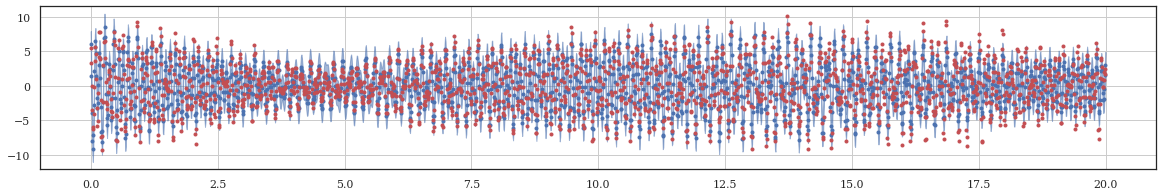

In [10]:
with torch.no_grad():
    pred_train_mu, pred_train_var = model._predict( inputs_new=x_train)
    #pred_train_mu, pred_train_var = model._predict_exact(inputs_new = x_train, diag=True)
    


plt.figure(figsize=(20,3))
if x_train.shape[1] == 1:
    plt.plot(x_train.cpu().data.numpy(),pred_train_mu.cpu().data.numpy(),'b.')
    plt.plot(x_train.cpu().data.numpy(),y_train.cpu().data.numpy(),'r.')
    plt.fill_between( x_train.cpu().data.numpy().squeeze(),
                      pred_train_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
                      pred_train_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
                      alpha = 0.5, edgecolor = 'b', facecolor = 'b')
else:
    plt.plot(pred_train_mu.cpu().data.numpy(),'b.')
    plt.plot(y_train.cpu().data.numpy(),'r.')
    

_evaluate_metric(pred_train_mu, pred_train_var, y_train)

# exact prediction for train set

(array(1.458), array(1.8489))

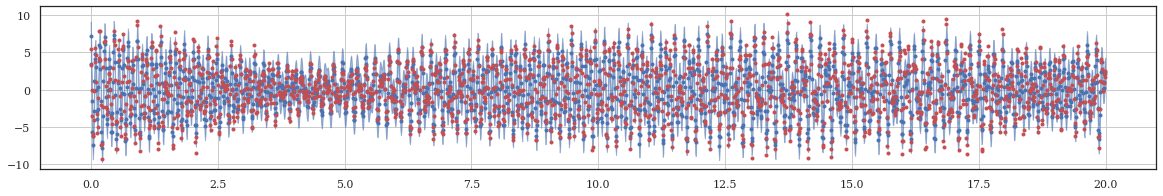

In [11]:
with torch.no_grad():
    #pred_train_mu, pred_train_var = model._predict( inputs_new=x_train)
    pred_train_mu, pred_train_var = model._predict_exact(inputs_new = x_train, diag=True)

plt.figure(figsize=(20,3))
if x_train.shape[1] == 1:
    plt.plot(x_train.cpu().data.numpy(),pred_train_mu.cpu().data.numpy(),'b.')
    plt.plot(x_train.cpu().data.numpy(),y_train.cpu().data.numpy(),'r.')
    plt.fill_between( x_train.cpu().data.numpy().squeeze(),
                      pred_train_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
                      pred_train_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
                      alpha = 0.5, edgecolor = 'b', facecolor = 'b')
else:
    plt.plot(pred_train_mu.cpu().data.numpy(),'b.')
    plt.plot(y_train.cpu().data.numpy(),'r.')
    

_evaluate_metric(pred_train_mu, pred_train_var, y_train)

# approximate prediction for test set

(array(4.5258), array(3.9535))

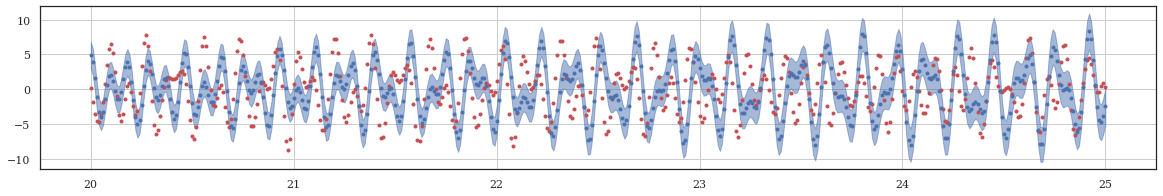

In [14]:
with torch.no_grad():
    pred_test_mu, pred_test_var = model._predict(inputs_new = x_test, diag=True)    
    #pred_test_mu, pred_test_var = model._predict_exact(inputs_new = x_test, diag=True)

plt.figure(figsize=(20,3))
if x_test.shape[1] == 1:
    plt.plot(x_test.cpu().data.numpy(),y_test.cpu().data.numpy(),'r.')
    plt.plot(x_test.cpu().data.numpy(),pred_test_mu.cpu().data.numpy(),'b.')
    plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                      pred_test_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                      pred_test_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                      alpha = 0.5, edgecolor = 'b', facecolor = 'b')
else:   
    plt.plot(pred_test_mu.cpu().data.numpy(),'b.')

_evaluate_metric(pred_test_mu, pred_test_var, y_test)

# exact predictin for test set

(array(3.7574), array(2.5886))

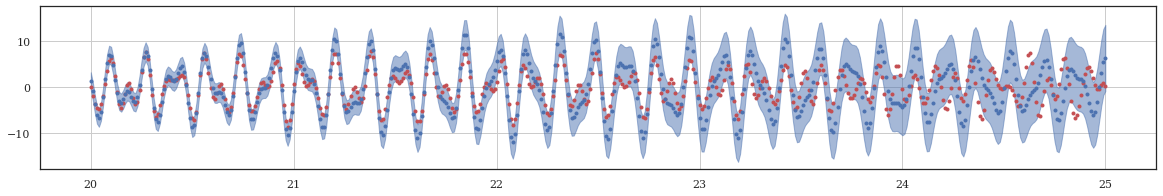

In [15]:
with torch.no_grad():
    #pred_test_mu, pred_test_var = model._predict(inputs_new = x_test, diag=True)    
    pred_test_mu, pred_test_var = model._predict_exact(inputs_new = x_test, diag=True)

plt.figure(figsize=(20,3))
if x_test.shape[1] == 1:
    plt.plot(x_test.cpu().data.numpy(),y_test.cpu().data.numpy(),'r.')
    plt.plot(x_test.cpu().data.numpy(),pred_test_mu.cpu().data.numpy(),'b.')
    plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                      pred_test_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                      pred_test_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                      alpha = 0.5, edgecolor = 'b', facecolor = 'b')
else:   
    plt.plot(pred_test_mu.cpu().data.numpy(),'b.')

_evaluate_metric(pred_test_mu, pred_test_var, y_test)